### Model Development based on Down-Sampling to achieve balanced sample

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import os, sys
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer,recall_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline  

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
import pickle

In [2]:
df=pd.read_csv('/dsa/groups/casestudy2021f/group_2/curated_data_m2.csv')

In [3]:
#online_instore classification corrected based on 
#https://www.aibms.com/wp-content/uploads/2014/12/GL_OPS_1205003.pdf
def online_instore(x):
    if x == 2 or x == 5 or x ==90 or x==80:
        return 'instore'
    
    elif x == 9:
        return 'electronic'
    else:
        return 'missing'

df['iselectronic'] = df['posentrymode'].apply(online_instore)
# df.loc[:,('posconditioncode','pos_description','posentrymode','iselectronic')].value_counts()

In [4]:
# adding pos condition code description based on https://www.mreports.com/documentation/ac/nonmerchant/80449.htm
def poscondition_desc(x):
    if x == 1:
        return 'card holder not present'
    elif x == 8:
        return 'mail/telephone order'
    else:
        return 'missing'
df['posconditioncode_desc'] = df['posconditioncode'].apply(poscondition_desc)

In [5]:
null_count = df.isnull().sum().sort_values(ascending = False)

percent = (df.isnull().sum()/(df.shape[0])*100)
missing_df = pd.concat([null_count, percent], axis=1, keys=['missing_values', 'percent'])
missing_df

,missing_values,percent
merchantcity,786363,100.000000
recurringauthind,786363,100.000000
merchantstate,786363,100.000000
echobuffer,786363,100.000000
merchantzip,786363,100.000000
posonpremises,786363,100.000000
acqcountry,4562,0.580139
pos_description,4054,0.515538
posentrymode,4054,0.515538
merchantcountrycode,724,0.092069


In [6]:
#Index of features having all thier samples missing data
missing_all = missing_df.loc[missing_df['percent']==100,]
missing_all.index

Index(['merchantcity', 'recurringauthind', 'merchantstate', 'echobuffer',
       'merchantzip', 'posonpremises'],
      dtype='object')

In [7]:
#subset on curated dataset on columns not having 100% missing values
df_sub = df.loc[:,~df.columns.isin(missing_all.index)]
print(f"Original number of features -  {df.shape[1]} \nNumber of features with 100% missing values- {len(missing_all.index)} \nResulting number of features -{df_sub.shape[1]}")

Original number of features -  38 
Number of features with 100% missing values- 6 
Resulting number of features -32


In [8]:
#check if customer id and account id are different
df_sub.loc[df_sub['customerid'] != df_sub['accountnumber']]

,Unnamed: 0,accountnumber,accountopendate,acqcountry,amount_classify,availablemoney,cardcvv,cardlast4digits,cardpresent,creditlimit,...,month,pos_description,posconditioncode,posentrymode,transactionamount,transactiondatetime,transactiontype,year,iselectronic,posconditioncode_desc


In [9]:
#remove features, unnamed is a redundant index, 
#accountnumber and customerid are only indexes/labels pertaining to each transaction
#merchantname and merchant_name_uq are deleted since vizulization revealed no pattern
#transactiondate time is being replaced by day, month and year
#since there are no fraud transactions distributions by merchant code show no clustering and hence removing the column
#pos_description is represented by posentrymode
#posconditioncode_desc is represented by posconditioncode

df_sub = df_sub.loc[:,~df_sub.columns.isin(['Unnamed: 0','accountnumber','customerid','merchantname','transactiondatetime',
                                            'merchant_name_uq','pos_description','posconditioncode_desc'])]
df_sub.columns

Index(['accountopendate', 'acqcountry', 'amount_classify', 'availablemoney',
       'cardcvv', 'cardlast4digits', 'cardpresent', 'creditlimit',
       'currentbalance', 'currentexpdate', 'dateoflastaddresschange', 'day',
       'enteredcvv', 'expirationdatekeyinmatch', 'isfraud',
       'merchantcategorycode', 'merchantcountrycode', 'month',
       'posconditioncode', 'posentrymode', 'transactionamount',
       'transactiontype', 'year', 'iselectronic'],
      dtype='object')

In [10]:
#features having dates
date_columns =  []
for col in df_sub.columns:
    if col.endswith('date') or col.startswith('date') :
        date_columns.append(col)
print('date type columns:', date_columns)

date type columns: ['accountopendate', 'currentexpdate', 'dateoflastaddresschange']


In [11]:
#exclude features with datatype as date
df_sub = df_sub.loc[:,~df_sub.columns.isin(date_columns)]
df_sub.columns

Index(['acqcountry', 'amount_classify', 'availablemoney', 'cardcvv',
       'cardlast4digits', 'cardpresent', 'creditlimit', 'currentbalance',
       'day', 'enteredcvv', 'expirationdatekeyinmatch', 'isfraud',
       'merchantcategorycode', 'merchantcountrycode', 'month',
       'posconditioncode', 'posentrymode', 'transactionamount',
       'transactiontype', 'year', 'iselectronic'],
      dtype='object')

In [12]:
df_sub.dtypes

acqcountry                   object
amount_classify              object
availablemoney              float64
cardcvv                       int64
cardlast4digits               int64
cardpresent                    bool
creditlimit                   int64
currentbalance              float64
day                           int64
enteredcvv                    int64
expirationdatekeyinmatch       bool
isfraud                        bool
merchantcategorycode         object
merchantcountrycode          object
month                         int64
posconditioncode            float64
posentrymode                float64
transactionamount           float64
transactiontype              object
year                          int64
iselectronic                 object
dtype: object

In [13]:
#missing value imputation based on mode

df_sub_missing = missing_df.loc[df_sub.columns,]
df_sub_missing['data_type'] = [df[x].dtypes for x in df_sub_missing.index]
print(df_sub_missing.loc[df_sub_missing['missing_values']!=0,])


for col in df_sub_missing.index:
    df_sub[col]= df_sub[col].fillna(df_sub[col].mode()[0])

                     missing_values   percent data_type
acqcountry                     4562  0.580139    object
merchantcountrycode             724  0.092069    object
posconditioncode                409  0.052012   float64
posentrymode                   4054  0.515538   float64
transactiontype                 698  0.088763    object


In [14]:
#one-hot encoding for all the features with categorical datatype
df_sub = pd.get_dummies(df_sub, columns =df_sub.dtypes[df_sub.dtypes == object].index )

In [15]:
with open('df_sub','wb') as f:
    pickle.dump(df_sub,f)

In [16]:
df_sub.dtypes

availablemoney                               float64
cardcvv                                        int64
cardlast4digits                                int64
cardpresent                                     bool
creditlimit                                    int64
currentbalance                               float64
day                                            int64
enteredcvv                                     int64
expirationdatekeyinmatch                        bool
isfraud                                         bool
month                                          int64
posconditioncode                             float64
posentrymode                                 float64
transactionamount                            float64
year                                           int64
acqcountry_CAN                                 uint8
acqcountry_MEX                                 uint8
acqcountry_PR                                  uint8
acqcountry_US                                 

### Model development
Due to heavy imbalance in the data relating to  the classes (Fraud and Not_Fraud) an initial sample drawn is downsampled. On this downsampled data, training and testing is being done using feature extraction, selection and classifier models. Feature extraction methods used are  PCA and feature selection methods used are  SelectKbest based on mutual info. Classifiers used are Logistic Regression and Ensemble classifiers like Extraclassifier, Adaboost, Gradient Boost and Random forests. The classifiers are fined tuned for the hyperparameters by running brute-force tuning method, Gridsearch. <br>
The classifiers, as can be seen in the model 2, model 3 which are ensemble methods yield a re_call score of 0.71. The best model is being re-trained on the entire downsample and then tested on the data that is NOT in the initial sample. 

Testing this final retrained model on the entire downsampled data produced consistent results of good re-call score of 0.70. 

In [17]:
df_sub_sample = df_sub.sample(frac = 0.80)
df_sub_sample_fraud = df_sub_sample.loc[df_sub_sample['isfraud']==True,]
df_sub_sample_notfraud = df_sub_sample.loc[df_sub_sample['isfraud']==False,]
df_sub_sample_notfraud_ds = df_sub_sample_notfraud.sample(n=df_sub_sample_fraud.shape[0],axis=0,replace=False)
df_sample_balanced = pd.concat([df_sub_sample_fraud,df_sub_sample_notfraud_ds], axis = 0 )

print('df_sub_sample_fraud', df_sub_sample_fraud.shape)

print('df_sub_sample_notfraud', df_sub_sample_notfraud.shape)
print('df_sub_sample_notfraud_ds', df_sub_sample_notfraud_ds.shape)
print('df_sample_balanced', df_sample_balanced.shape)

df_sub_sample_index = df_sub_sample.index





del df_sub_sample
del df_sub_sample_fraud
del df_sub_sample_notfraud
del df_sub_sample_notfraud_ds



df_sub_sample_fraud (9869, 55)
df_sub_sample_notfraud (619221, 55)
df_sub_sample_notfraud_ds (9869, 55)
df_sample_balanced (19738, 55)


In [18]:
X = df_sample_balanced.loc[:,~df_sample_balanced.columns.isin(['isfraud'])]
y= df_sample_balanced['isfraud']
df_sample_cols = X.columns                      
del df_sample_balanced

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# del X
# del y


### Model - 1
Feature extraction  - PCA
Classifer - Logistic Regression

In [20]:
pipe = Pipeline([('PCA', PCA(n_components=5)), 
                 ('LogisticRegression', LogisticRegression(C=1,max_iter=5000))])

param_grid = {'PCA__n_components': [3,4,5],
              'LogisticRegression__C': [0.001,.01,1,5,10]}

# ftwo_scorer = make_scorer(fbeta_score, beta=2)

recall_custom_scorer = make_scorer(
    lambda y, y_pred, **kwargs: recall_score(y, y_pred, pos_label=1)
)
model_grid = GridSearchCV(pipe, param_grid, n_jobs=5,cv=5, scoring=recall_custom_scorer )


model_grid = GridSearchCV(pipe, param_grid, n_jobs=5,cv=5, scoring=recall_custom_scorer)
model_grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA(n_components=5)),
                                       ('LogisticRegression',
                                        LogisticRegression(C=1,
                                                           max_iter=5000))]),
             n_jobs=5,
             param_grid={'LogisticRegression__C': [0.001, 0.01, 1, 5, 10],
                         'PCA__n_components': [3, 4, 5]},
             scoring=make_scorer(<lambda>))

In [21]:
print(classification_report(y_test,model_grid.predict(X_test)))


pd.crosstab(y_test,model_grid.predict(X_test),rownames=['Actual'],colnames=['Predicted'],dropna=False,margins=True)

              precision    recall  f1-score   support

       False       0.51      0.52      0.52      1992
        True       0.50      0.49      0.50      1956

    accuracy                           0.51      3948
   macro avg       0.51      0.51      0.51      3948
weighted avg       0.51      0.51      0.51      3948



Predicted,False,True,All
Actual,,,
False,1042,950,1992
True,994,962,1956
All,2036,1912,3948


In [22]:
print("feature reduction parameters==>, {}, \n classifier parameters ==>"
      .format([(key, value) for key, value in dict.items(model_grid.best_params_)][0]),
      [(key, value) for key, value in dict.items(model_grid.best_params_)][1])

feature reduction parameters==>, ('LogisticRegression__C', 0.001), 
 classifier parameters ==> ('PCA__n_components', 4)


### Model - 2
Feature selection  - Filter method by selecting the best features based on univariate statistic, the mutual_info_classification which measures the dependency between the target  and features. <br>
Classifer - ensemble method, the RandomForestClassifier 

In [23]:
#feature selection - filter method
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

pipe1 = Pipeline([('selector', SelectKBest(mutual_info_classif, k=5)),
                  ('classifier', RandomForestClassifier(n_estimators=20,max_depth=5))],verbose=True)

param_grid = {'selector__k': [5,7,9],'classifier__n_estimators': [10,15,20],'classifier__max_depth':[5,7,9]}




model_grid1 = GridSearchCV(pipe1, param_grid, n_jobs=5,cv=5, scoring=recall_custom_scorer)
model_grid1.fit(X_train,y_train)


[Pipeline] .......... (step 1 of 2) Processing selector, total=   5.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selector',
                                        SelectKBest(k=5,
                                                    score_func=<function mutual_info_classif at 0x7f0ffd3c4f28>)),
                                       ('classifier',
                                        RandomForestClassifier(max_depth=5,
                                                               n_estimators=20))],
                                verbose=True),
             n_jobs=5,
             param_grid={'classifier__max_depth': [5, 7, 9],
                         'classifier__n_estimators': [10, 15, 20],
                         'selector__k': [5, 7, 9]},
             scoring=make_scorer(<lambda>))

In [24]:
print(classification_report(y_test,model_grid1.predict(X_test)))


pd.crosstab(y_test,model_grid1.predict(X_test),rownames=['Actual'],colnames=['Predicted'],dropna=False,margins=True)

              precision    recall  f1-score   support

       False       0.68      0.61      0.64      1992
        True       0.64      0.71      0.67      1956

    accuracy                           0.66      3948
   macro avg       0.66      0.66      0.66      3948
weighted avg       0.66      0.66      0.66      3948



Predicted,False,True,All
Actual,,,
False,1221,771,1992
True,575,1381,1956
All,1796,2152,3948


In [25]:
print("feature reduction parameters==>, {}, \n classifier parameters ==>"
      .format([(key, value) for key, value in dict.items(model_grid1.best_params_)][0]),
      [(key, value) for key, value in dict.items(model_grid1.best_params_)][1])

feature reduction parameters==>, ('classifier__max_depth', 9), 
 classifier parameters ==> ('classifier__n_estimators', 20)


### Model - 3(includes model 2 feature selection and its parameters)
Feature selection  - used model2 feature selection since the model resulted in promising results. <br>
Classifer - since promissing results were seen using ensemble classification methods, more ensaemble techniques like RandomForestclassifier, ExtreeForest, Adaboost,GradientBoost were taken

In [26]:
class ClassiferHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
#             print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [27]:
model3_kbest = SelectKBest(mutual_info_classif, k=9)
X_train_new  = model3_kbest.fit_transform(X_train, y_train)

In [28]:
model3_kbest.get_support(indices=True)

array([ 1,  2,  3,  7, 11, 12, 23, 32, 52])

In [29]:

models1 = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
#     ,
#     'SVC': SVC()
}

params1 = {
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'RandomForestClassifier': { 'n_estimators': [10, 15,20],'max_depth':[5,7,9]},
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] }
#     'SVC': [
#         {'kernel': ['linear'], 'C': [0.025]}]
}
        


In [30]:
helper1 = ClassiferHelper(models1, params1)
helper1.fit(X_train_new, y_train, scoring=recall_custom_scorer, n_jobs=2)

Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [31]:
helper1.score_summary(sort_by='max_score')

,estimator,min_score,mean_score,max_score,std_score,n_estimators,max_depth,learning_rate
11,AdaBoostClassifier,0.691695,0.702387,0.721001,0.01321,16,NaN,NaN
12,AdaBoostClassifier,0.688021,0.698218,0.708112,0.008205,32,NaN,NaN
16,GradientBoostingClassifier,0.680061,0.689246,0.697877,0.007284,32,NaN,1.0
15,GradientBoostingClassifier,0.650493,0.678126,0.694845,0.019683,16,NaN,1.0
14,GradientBoostingClassifier,0.6721,0.684949,0.694086,0.009352,32,NaN,0.8
8,RandomForestClassifier,0.650114,0.673198,0.691695,0.017283,10,9,NaN
13,GradientBoostingClassifier,0.657695,0.672817,0.686126,0.011677,16,NaN,0.8
9,RandomForestClassifier,0.653904,0.664855,0.676649,0.009305,15,9,NaN
10,RandomForestClassifier,0.643669,0.66334,0.675009,0.01399,20,9,NaN
3,RandomForestClassifier,0.607278,0.650325,0.673237,0.03046,15,5,NaN


In [32]:
results = helper1.score_summary(sort_by='max_score')
selected_model = results.loc[results['max_score'].index[0],'estimator']
selected_model_param = results.loc[results['max_score'].index[0],'n_estimators']

pipe3 = Pipeline([(selected_model, models1[selected_model])])
param_grid = {selected_model+'__n_estimators':[selected_model_param] }
model_grid3 = GridSearchCV(pipe3, param_grid, n_jobs=5, scoring=recall_custom_scorer,verbose= True)
model_grid3

GridSearchCV(estimator=Pipeline(steps=[('AdaBoostClassifier',
                                        AdaBoostClassifier())]),
             n_jobs=5, param_grid={'AdaBoostClassifier__n_estimators': [16]},
             scoring=make_scorer(<lambda>), verbose=True)

In [33]:
cols = model3_kbest.get_support(indices=True)
X_test_new = X_test.iloc[:,cols]
model_grid3.fit(X_test_new,y_test)
print(classification_report(y_test,model_grid3.predict(X_test_new)))
pd.crosstab(y_test,model_grid3.predict(X_test_new),rownames=['Actual'],colnames=['Predicted'],dropna=False,margins=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

       False       0.68      0.64      0.66      1992
        True       0.65      0.69      0.67      1956

    accuracy                           0.67      3948
   macro avg       0.67      0.67      0.67      3948
weighted avg       0.67      0.67      0.67      3948



Predicted,False,True,All
Actual,,,
False,1272,720,1992
True,599,1357,1956
All,1871,2077,3948


## Final model
Feature selection based on model3 <br>
and classifier too is based on best classifier score of model 3

In [34]:
del df
final_kbest  = SelectKBest(mutual_info_classif, k=9)

# final_X_train = final_kbest.fit_transform(df_sub.iloc[df_sub.index.isin(df_sub_sample_index),~df_sub.columns.isin(['isfraud'])], 
#                           df_sub.loc[df_sub.index.isin(df_sub_sample_index), 'isfraud'])
final_X_train = final_kbest.fit_transform(X,y)
final_cols = final_kbest.get_support(indices=True)
final_cols


array([ 1,  2,  3,  7, 11, 12, 23, 51, 52])

In [35]:
print("features selected for the model \n",X.columns[final_cols])

features selected for the model 
 Index(['cardcvv', 'cardlast4digits', 'cardpresent', 'enteredcvv',
       'posentrymode', 'transactionamount', 'amount_classify_<$50',
       'iselectronic_electronic', 'iselectronic_instore'],
      dtype='object')


Text(0.5, 1.0, 'Features and mutual_info_scores')

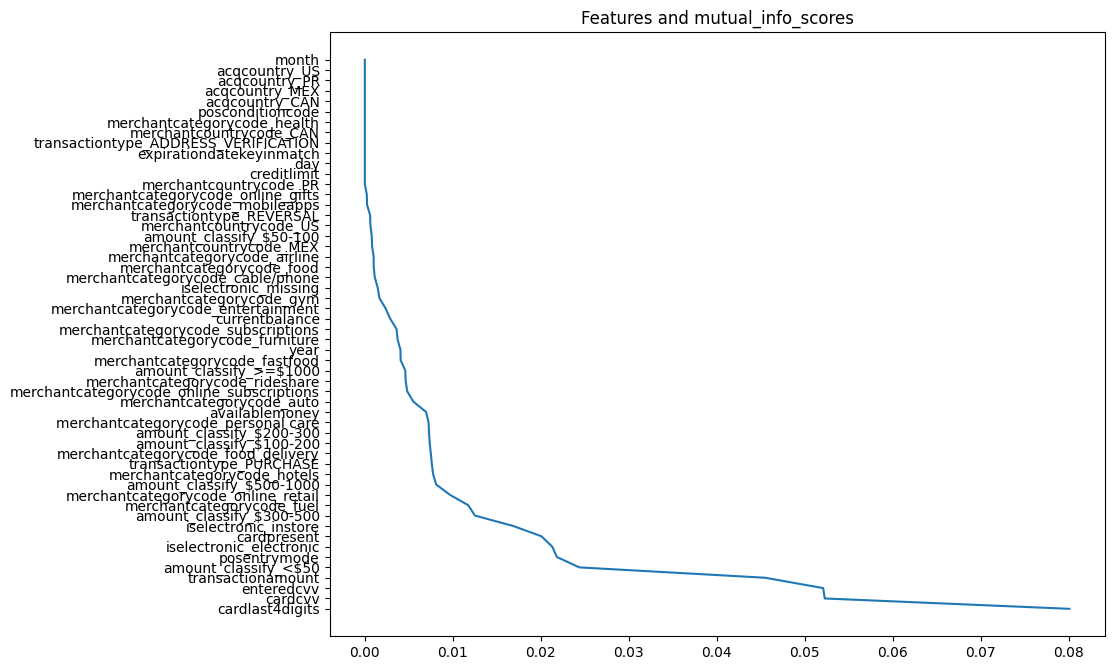

In [36]:
final_kbest_df = pd.DataFrame({'features':X.columns,
             'scores':final_kbest.scores_, 
             'seleted':final_kbest.get_support()}).sort_values(by= 'scores', ascending = False).reset_index(drop =True)

fig, ax = plt.subplots( figsize = (10,8))
fig.set_dpi(100)
ax.plot(final_kbest_df.scores,final_kbest_df.features)
ax.set_title("Features and mutual_info_scores")

In [37]:
final_kbest_df.head(n=9)

,features,scores,seleted
0,cardlast4digits,0.080061,True
1,cardcvv,0.052266,True
2,enteredcvv,0.052081,True
3,transactionamount,0.045481,True
4,amount_classify_<$50,0.024376,True
5,posentrymode,0.021825,True
6,iselectronic_electronic,0.021301,True
7,cardpresent,0.020075,True
8,iselectronic_instore,0.016852,True


In [38]:
final_pipe = Pipeline([(selected_model, models1[selected_model])])
param_grid_final = param_grid

final_model = GridSearchCV(final_pipe, param_grid_final, n_jobs=5, scoring=recall_custom_scorer,verbose= True)
# final_model.fit(final_X_train, df_sub.loc[df_sub.index.isin(df_sub_sample_index), 'isfraud'])
final_model.fit(X.iloc[:,final_cols], y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=Pipeline(steps=[('AdaBoostClassifier',
                                        AdaBoostClassifier())]),
             n_jobs=5, param_grid={'AdaBoostClassifier__n_estimators': [16]},
             scoring=make_scorer(<lambda>), verbose=True)

In [39]:
final_model.cv_results_

{'mean_fit_time': array([0.41030045]),
 'std_fit_time': array([0.00823318]),
 'mean_score_time': array([0.04309525]),
 'std_score_time': array([0.010255]),
 'param_AdaBoostClassifier__n_estimators': masked_array(data=[16],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'AdaBoostClassifier__n_estimators': 16}],
 'split0_test_score': array([0.67527862]),
 'split1_test_score': array([0.704154]),
 'split2_test_score': array([0.69047619]),
 'split3_test_score': array([0.71732523]),
 'split4_test_score': array([0.72630512]),
 'mean_test_score': array([0.70270783]),
 'std_test_score': array([0.01830064]),
 'rank_test_score': array([1], dtype=int32)}

In [40]:
print("Final model testing results on the un-balanced test data")
print("*"*100)
X_final_test = df_sub.loc[~df_sub.index.isin(df_sub_sample_index),X.columns[final_cols]]
y_final_test = df_sub.loc[~df_sub.index.isin(df_sub_sample_index), 'isfraud']

print(classification_report(y_final_test,final_model.predict(X_final_test)))
pd.crosstab(y_final_test,final_model.predict(X_final_test),rownames=['Actual'],colnames=['Predicted'],dropna=False,margins=True)

Final model testing results on the un-balanced test data
****************************************************************************************************
              precision    recall  f1-score   support

       False       0.99      0.64      0.78    154725
        True       0.03      0.70      0.06      2548

    accuracy                           0.64    157273
   macro avg       0.51      0.67      0.42    157273
weighted avg       0.98      0.64      0.76    157273



Predicted,False,True,All
Actual,,,
False,98689,56036,154725
True,766,1782,2548
All,99455,57818,157273


In [41]:
len(df_sub_sample_index)+df_sub.iloc[~df_sub.index.isin(df_sub_sample_index), ].shape[0]

786363

In [42]:
import sys# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']# Get a sorted list of the objects and their sizes
temp = sorted([(x, sys.getsizeof(globals().get(x))/1024)
        for x in dir() 
        if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
df_temp = pd.DataFrame(temp, columns = ['variable', 'size_in_kilobytes'])
df_temp.head()



,variable,size_in_kilobytes
0,df_sub,106742.782227
1,X_final_test,7986.542969
2,y_final_test,5510.344727
3,df_sub_sample_index,4914.789062
4,X,2814.230469
